# Kevin Hillstrom MineThatData
## Email Analytics
코드 참조:

[머신러닝 실무 프로젝트 깃허브](https://github.com/flourscent/ml-at-work/blob/master/chap09/Kevin_Hillstrom_MineThatData_E-MailAnalytics.ipynb)

[코드 추가 설명](https://partrita.github.io/posts/python-uplift/)

- 과거 12개월 구매 이력이 있는 고객 대상
- '남성 타겟 판촉 메일', '여성 타겟 판촉 메일', '메일 발송X' 수행
- 우선적으로 방문 여부 조사(구매 전환 X)


### Data Load

In [2]:
import urllib.request
csv_url = "http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
csv_filename = "source_data.csv"
with open(csv_filename, 'w') as f:
    data = urllib.request.urlopen(csv_url).read()
    f.write(data.decode('ascii'))

In [3]:
import pandas as pd 
source_df = pd.read_csv(csv_filename)
source_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


![image](https://user-images.githubusercontent.com/68543150/141747317-a9bd7d59-61a4-4298-bd6d-c472947bebcf.png)


### Preprocessing

In [4]:
source_df['segment'].unique()

array(['Womens E-Mail', 'No E-Mail', 'Mens E-Mail'], dtype=object)

In [5]:
# 메일을 받지 않은 고객 데이터 삭제
mailed_df = source_df.loc[source_df['segment'] != 'No E-Mail'].reset_index(drop=True)
mailed_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
2,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
3,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
4,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0


In [6]:
print(mailed_df.shape)
print(source_df.shape)

(42694, 12)
(64000, 12)


In [7]:
mailed_df.dtypes

recency              int64
history_segment     object
history            float64
mens                 int64
womens               int64
zip_code            object
newbie               int64
channel             object
segment             object
visit                int64
conversion           int64
spend              float64
dtype: object

In [8]:
# 원핫인코딩
dummied_df = pd.get_dummies(mailed_df[['zip_code', 'channel']], drop_first=True) # zip_code, channel 변경, 첫번째 컬럼 제거(다중공선성)
feature_vector_df = mailed_df.drop(['history_segment', 'zip_code', 'channel', 'segment', 'visit', 'conversion', 'spend'], axis=1)
feature_vector_df = pd.concat([feature_vector_df, dummied_df], axis=1)
feature_vector_df.head()

,recency,history,mens,womens,newbie,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,1,0
1,7,180.65,0,1,1,1,0,0,1
2,9,675.83,1,0,1,0,0,0,1
3,2,45.34,1,0,0,0,1,0,1
4,6,134.83,0,1,0,1,0,1,0


In [9]:
# 남성 타겟 메일 받은 고객 중 사이트에 방문한 데이터 분리
is_treat_list = list(mailed_df['segment'] == 'Mens E-Mail') # 남성 타겟 메일 boolean
is_cv_list = list(mailed_df['visit'] == 1) # 메일 받은 고객 중 방문한 고객 boolean

### Training

In [11]:
from sklearn.model_selection import train_test_split

train_is_cv_list, test_is_cv_list,\
train_is_treat_list, test_is_treat_list,\
train_feature_vector_df, test_feature_vector_df\
     = train_test_split(is_cv_list, is_treat_list, feature_vector_df, test_size=0.2, random_state=42)

In [12]:
# 로지스틱 회귀 모델
from sklearn.linear_model import LogisticRegression

treat_model = LogisticRegression(C=0.01, max_iter=1000)
control_model = LogisticRegression(C=0.01, max_iter=1000)

train_sample_num = len(train_is_cv_list) # train 데이터 개수

# 실험군
treat_is_cv_list = [train_is_cv_list[i] for i in range(train_sample_num) if train_is_treat_list[i]==True] # 남성 메일 중 방문 고객
treat_feature_vector_list = train_feature_vector_df[train_is_treat_list]

# 대조군
control_is_cv_list = [train_is_cv_list[i] for i in range(train_sample_num) if train_is_treat_list[i]==False] # 여성 메일 중 방문 고객
control_feature_vector_list = train_feature_vector_df[list(map(lambda x: x == False, train_is_treat_list))]

treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

LogisticRegression(C=0.01, max_iter=1000)

# Evaluate

In [13]:
from operator import itemgetter

treat_score = treat_model.predict_proba(test_feature_vector_df) # 실험군 예측값
control_score = control_model.predict_proba(test_feature_vector_df) # 대조군 예측값
score_list = treat_score[:, 1] - control_score[:, 1] # 실험군 - 대조군, 업리프트 모델링 점수 계산

result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2), reverse=True)

Text(0, 0.5, 'conversion rate')

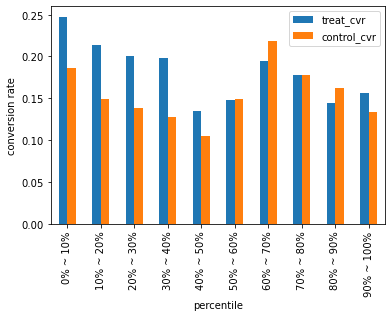

In [14]:
import matplotlib.pyplot as plt

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

quantile_data = []
for n in range(10):
    start = int(n * len(result) / 10) # 10% 단위
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]
    # 실험/대조 결과
    treat_uu = list(map(lambda item: item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item: item[1], quantiled_result)).count(False)
    # 전환 건수
    treat_cv = [item[0] for item in quantiled_result if item[1] == True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] == False].count(True)

    # 전환율 계산
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu

    quantile_data.append([treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr])

    label = "{}% ~ {}%".format(n*10, (n+1)*10)
    qdf.loc[label] = [treat_cvr, control_cvr]

qdf.plot(kind='bar')
plt.xlabel('percentile')
plt.ylabel('conversion rate')

- 60%까지는 남성 타겟 메일이 반응이 더 좋음
- 이후로는 여성이 우세

### Evalutate using AUC

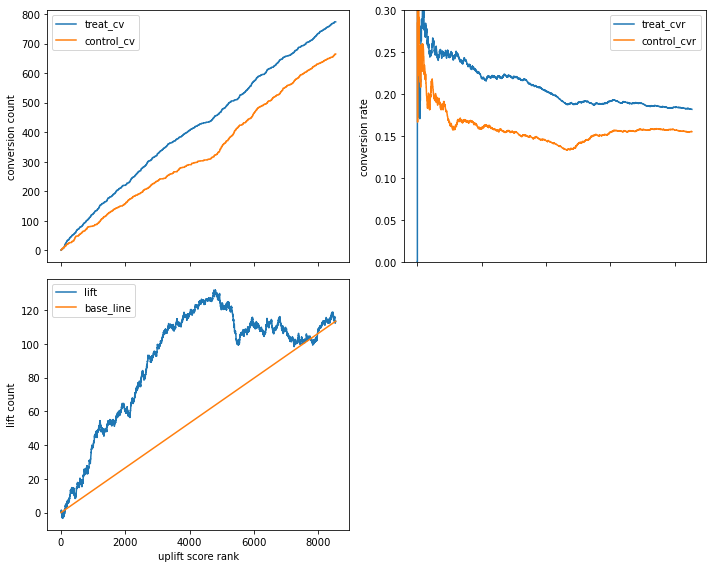

In [16]:
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
list = 0.0
stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu

    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu
    lift = (treat_cvr - control_cvr) * treat_uu
    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr, lift])

df = pd.DataFrame(stat_data)
df.columns = ['is_cv', 'is_treat', 'score', 'treat_uu', 'control_uu', 'treat_cv', 'control_cv', 'treat_cvr', 'control_cvr', 'lift']

df['base_line'] = df.index * df['lift'][len(df.index) - 1] / len(df.index)
f, ([ax0, ax1], [ax2, ax3]) = plt.subplots(2, 2, sharex=True, figsize=(10, 8))

df.plot(y=['treat_cv', 'control_cv'], ax=ax0)
ax0.set_xlabel('uplift score rank')
ax0.set_ylabel('conversion count')
df.plot(y=['treat_cvr', 'control_cvr'], ax=ax1, ylim=[0, 0.3])
ax1.set_xlabel('uplift score rank')
ax1.set_ylabel('conversion rate')
df.plot(y=['lift', 'base_line'], ax=ax2)
ax2.set_xlabel('uplift score rank')
ax2.set_ylabel('lift count')
ax3.axis('off')
plt.tight_layout()

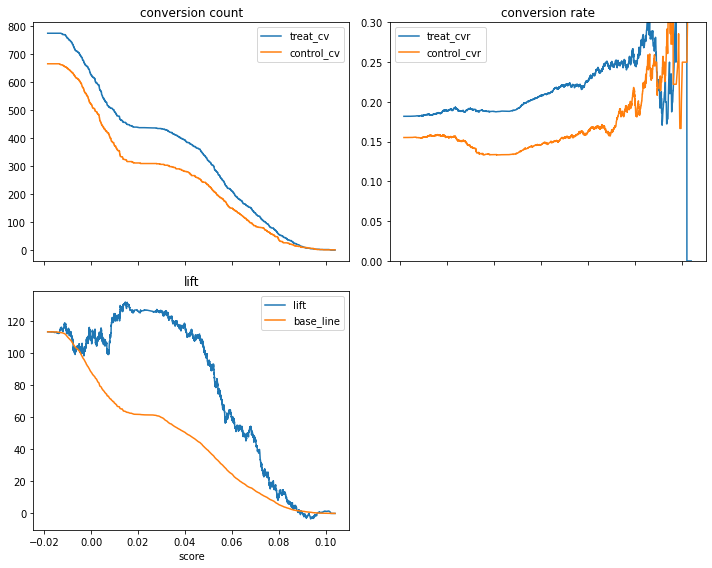

In [17]:
# 정규화 그림
f, ([ax0, ax1], [ax2, ax3]) = plt.subplots(2, 2, sharex=True, figsize=(10, 8))
df.plot(y=['treat_cv', 'control_cv'], ax=ax0, x='score', title='conversion count')
df.plot(y=['treat_cvr', 'control_cvr'], ylim=[0, 0.3], x='score', title='conversion rate', ax=ax1)
df.plot(y=['lift', 'base_line'], x='score', title='lift', ax=ax2)
ax3.axis('off')
plt.tight_layout()